In [1]:
from langchain_community.graphs import Neo4jGraph
# from neo4j.debug import watch
import pandas as pd
from pyprojroot import here
# watch("neo4j")

**Keep the following info as secret keys or in environment variables**

In [2]:
NEO4J_URL = "bolt://localhost:7687"
NEO4J_USERNAME = "neo4j"
NEO4J_PASSWORD = "12345678"
NEO4J_DATABASE = 'neo4j'

**Load an instance of the Graph DB**

In [3]:
graph = Neo4jGraph(url=NEO4J_URL, username=NEO4J_USERNAME, password=NEO4J_PASSWORD, database=NEO4J_DATABASE)

**Nodes:**
- `Movie`: Represents a movie. Each movie node has <u>attributes</u> such as **id** (a unique identifier for the movie), **released** (the release date of the movie), **title** (the movie's title), and **imdbRating** (the movie's rating on IMDb).
- `Person`: Represents an individual who can either be an <u>actor</u> or a <u>director</u> (or both) in movies. Each person node has a <u>single attribute</u>, **name**, which is the name of the person.
- `Genre`: Represents a movie genre. Each genre node has a <u>single attribute</u>, **name**, which is the genre type (e.g., Action, Comedy, Drama, etc.).
- `Location`: Represents the location where the movies was taken. Each location has a single attribute **name**, which is the name of the location (e.g: United States, United Kingdom)
- `SimilarMovie`: Rrpresents a similar movie to its corresponding movie. Each similar movie has a single attribute **name**, which is the name of the movie (e.g: Finding Nemo. Which is the similar movie for Toy story)

**Relationships:**
- `:DIRECTED`: A directional relationship from a Person node to a Movie node, signifying that the person directed the movie.
- `:ACTED_IN`: A directional relationship from a Person node to a Movie node, signifying that the person acted in the movie.
- `:IN_GENRE`: A directional relationship from a Movie node to a Genre node, signifying that the movie belongs to that particular genre.
- `:WAS_TAKEN_IN`: A directional relationship from a Movie node to a Location node, signifying that the movie was taken in that location.
- `:IS_SIMILAR_TO`: A directional relationship from a Movie node to a SimilarMovie node, signifying that movies is similar to the one we are looking at.

**Instructions in the script:**
- `LOAD CSV WITH HEADERS`: Loads a CSV file that contains the movie data with headers indicating each column's purpose.
- `MERGE`: Ensures that a node or relationship is created if it does not already exist; otherwise, it matches the existing node or relationship. This prevents duplication.
- `SET`: Assigns properties to the nodes after they've been created or matched.
- `FOREACH`: Executes the contained commands for each element in a list. This is used to iterate over the lists of directors, actors, and genres associated with each movie. It ensures that all the respective Person and Genre nodes are created and linked appropriately to the Movie nodes.

**To load the data withing cypher query:**

--------------------
- NOTE: Uncomment `dbms.security.allow_csv_import_from_file_urls=true` in `neo4j.conf` to be able to load the file locally.
- NOTE: Absolute path + no space for the file directory.
--------------------

**Loading the data for test:**

In [4]:
movie_csv_path = here("data/movie_csv/movie.csv")
print(pd.read_csv(movie_csv_path).columns)
print("DAta shape:", pd.read_csv(movie_csv_path).shape)

Index(['movieId', 'released', 'title', 'actors', 'director', 'genres',
       'imdbRating', 'similar_movie', 'tagline', 'location'],
      dtype='object')
DAta shape: (20, 10)


**The knowledge graph that we want to construct from our tabular data**

![Screenshot 2024-05-12 171636.png](<attachment:Screenshot 2024-05-12 171636.png>)
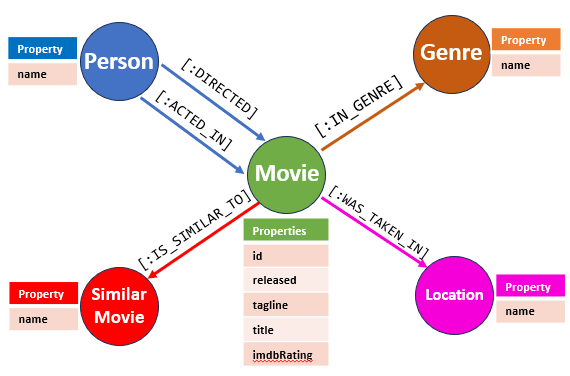

In [13]:
pd.read_csv(movie_csv_path).head(3)

,movieId,released,title,actors,director,genres,imdbRating,similar_movie,tagline,location
0,1,1995-11-22,Toy Story,Jim Varney|Tim Allen|Tom Hanks|Don Rickles,John Lasseter,Adventure|Animation|Children|Comedy|Fantasy,8.3,Finding Nemo,The adventure takes off!,United States
1,2,1995-12-15,Jumanji,Robin Williams|Bradley Pierce|Kirsten Dunst|Jo...,Joe Johnston,Adventure|Children|Fantasy,6.9,Jumanji: Welcome to the Jungle,Roll the dice and unleash the excitement!,United States
2,3,1995-12-22,Grumpier Old Men,Walter Matthau|Ann-Margret|Jack Lemmon|Sophia ...,Howard Deutch,Comedy|Romance,6.6,The Bucket List,Still Yelling. Still Fighting. Still Ready for...,United States


**Import movie information from the CSV file with tagline, construct the knowledge graph, and store the data in the Graph database**

In [14]:
graph.query("""
LOAD CSV WITH HEADERS FROM 'file:///' + $movie_directory    // Load CSV data from a file specified by $movie_directory
AS row                                                      // Each row in the CSV will be represented as 'row'
            
MERGE (m:Movie {id:row.movieId})                            // Merge a Movie node with the id from the row
SET m.released = date(row.released),                        // Set the 'released' property of the Movie node to the date from the row
    m.title = row.title,                                    // Set the 'title' property of the Movie node to the title from the row
    m.tagline = row.tagline,                                // Set the 'tagline' property of the Movie node to the tagline from the row
    m.imdbRating = toFloat(row.imdbRating)                  // Convert the 'imdbRating' from string to float and set it as the property
            
FOREACH (director in split(row.director, '|') |             // For each director in the list of directors from the row (split by '|') 
    MERGE (p:Person {name:trim(director)})                  // Merge a Person node with the director's name from the row, trimming any extra spaces
    MERGE (p)-[:DIRECTED]->(m))                             // Create a DIRECTED relationship from the director to the Movie
            
FOREACH (actor in split(row.actors, '|') |                  // For each actor in the list of actors from the row (split by '|') 
    MERGE (p:Person {name:trim(actor)})                     // Merge a Person node with the actor's name from the row, trimming any extra spaces
    MERGE (p)-[:ACTED_IN]->(m))                             // Create an ACTED_IN relationship from the actor to the Movie
            
FOREACH (genre in split(row.genres, '|') |                  // For each genre in the list of genres from the row (split by '|')
    MERGE (g:Genre {name:trim(genre)})                      // Merge a Genre node with the genre's name from the row, trimming any extra spaces
    MERGE (m)-[:IN_GENRE]->(g))                             // Create an IN_GENRE relationship from the Movie to the Genre
            
MERGE (l:Location {name:trim(row.location)})
MERGE (m)-[:WAS_TAKEN_IN]->(l)

MERGE (s:SimilarMovie {name:trim(row.similar_movie)})
MERGE (m)-[:IS_SIMILAR_TO]->(s)                                            
""",
params={"movie_directory": str(movie_csv_path)})            # Pass the parameter 'movie_directory' which contains the path to the CSV file

[]

**Print the graph database schema and verify the knowledge graph**

In [16]:
graph.refresh_schema()
print(graph.schema)

Node properties are the following:
Movie {imdbRating: FLOAT, tagline: STRING, id: STRING, released: DATE, title: STRING},Person {name: STRING},Genre {name: STRING},Location {name: STRING},SimilarMovie {name: STRING}
Relationship properties are the following:

The relationships are the following:
(:Movie)-[:IN_GENRE]->(:Genre),(:Movie)-[:WAS_TAKEN_IN]->(:Location),(:Movie)-[:IS_SIMILAR_TO]->(:SimilarMovie),(:Person)-[:DIRECTED]->(:Movie),(:Person)-[:ACTED_IN]->(:Movie)


**Check the number of nodes that were created from the data (original shape of data: `(20, 9)`)**

In [17]:
# Match all nodes in the graph
cypher = """
  MATCH (n) 
  RETURN count(n)
  """
result = graph.query(cypher)
result

[{'count(n)': 155}]

### **Create vector embedding from the `tagline` column for RAG**

In [19]:
import os
import pandas as pd
from dotenv import load_dotenv
load_dotenv()

True

In [20]:
movie_csv_path = here("data/movie_csv/movie.csv")
df = pd.read_csv(movie_csv_path)
print(df.columns)
df.head(3)

Index(['movieId', 'released', 'title', 'actors', 'director', 'genres',
       'imdbRating', 'similar_movie', 'tagline', 'location'],
      dtype='object')


,movieId,released,title,actors,director,genres,imdbRating,similar_movie,tagline,location
0,1,1995-11-22,Toy Story,Jim Varney|Tim Allen|Tom Hanks|Don Rickles,John Lasseter,Adventure|Animation|Children|Comedy|Fantasy,8.3,Finding Nemo,The adventure takes off!,United States
1,2,1995-12-15,Jumanji,Robin Williams|Bradley Pierce|Kirsten Dunst|Jo...,Joe Johnston,Adventure|Children|Fantasy,6.9,Jumanji: Welcome to the Jungle,Roll the dice and unleash the excitement!,United States
2,3,1995-12-22,Grumpier Old Men,Walter Matthau|Ann-Margret|Jack Lemmon|Sophia ...,Howard Deutch,Comedy|Romance,6.6,The Bucket List,Still Yelling. Still Fighting. Still Ready for...,United States


In [23]:
model_name = "gpt-35-turbo-1106"
# model_name = "gpt-35-turbo"
azure_openai_api_key = os.environ["OPENAI_API_KEY"]
azure_openai_endpoint = os.environ["OPENAI_API_BASE"]

**Load the Azure OpenAI Embedding Model**

In [24]:
from openai import AzureOpenAI
from typing import List

client = AzureOpenAI(
  api_key = azure_openai_api_key,  
  api_version = "2023-07-01-preview",
  azure_endpoint = azure_openai_endpoint
)

def embed_text(text:str)->List:
    """
    Embeds the given text using the specified model.

    Parameters:
        text (str): The text to be embedded.

    Returns:
        List: A list containing the embedding of the text.
    """
    response = client.embeddings.create(
    input = text,
    model= "text-embedding-ada-002"
    )
    return response.data[0].embedding

In [25]:
df["tagline"][:3]

0                             The adventure takes off!
1            Roll the dice and unleash the excitement!
2    Still Yelling. Still Fighting. Still Ready for...
Name: tagline, dtype: object

In [26]:
embedding_list = [embed_text(i) for i in df["tagline"]]

In [27]:
print("Number of vectors:", len(embedding_list))
print("Embedding dimension:", len(embedding_list[0]))
embedding_list[0][:5]

Number of vectors: 20
Embedding dimension: 1536


[0.023812185972929,
 -0.036298904567956924,
 -0.006856604944914579,
 -0.012976010330021381,
 -0.020980820059776306]

In [28]:
df["taglineEmbedding"] = embedding_list
df.head(3)

,movieId,released,title,actors,director,genres,imdbRating,similar_movie,tagline,location,taglineEmbedding
0,1,1995-11-22,Toy Story,Jim Varney|Tim Allen|Tom Hanks|Don Rickles,John Lasseter,Adventure|Animation|Children|Comedy|Fantasy,8.3,Finding Nemo,The adventure takes off!,United States,"[0.023812185972929, -0.036298904567956924, -0...."
1,2,1995-12-15,Jumanji,Robin Williams|Bradley Pierce|Kirsten Dunst|Jo...,Joe Johnston,Adventure|Children|Fantasy,6.9,Jumanji: Welcome to the Jungle,Roll the dice and unleash the excitement!,United States,"[-0.005139722488820553, -0.015951087698340416,..."
2,3,1995-12-22,Grumpier Old Men,Walter Matthau|Ann-Margret|Jack Lemmon|Sophia ...,Howard Deutch,Comedy|Romance,6.6,The Bucket List,Still Yelling. Still Fighting. Still Ready for...,United States,"[-0.02191801927983761, -0.022048715502023697, ..."


**Create a vector index**

In [29]:
graph.query("""
  CREATE VECTOR INDEX movie_tagline_embeddings IF NOT EXISTS      // Create a vector index named 'movie_tagline_embeddings' if it doesn't already exist  
  FOR (m:Movie) ON (m.taglineEmbedding)                           // Index the 'taglineEmbedding' property of Movie nodes 
  OPTIONS { indexConfig: {                                        // Set options for the index
    `vector.dimensions`: 1536,                                    // Specify the dimensionality of the vector space (1536 dimensions)
    `vector.similarity_function`: 'cosine'                        // Specify the similarity function to be cosine similarity
  }}"""
)

[]

Executing this query will return details such as the names of the indexes, the node labels they are created for, the properties they index, and the configuration options of each index. It's a way to inspect the existing vector indexes in the database.

In [30]:
graph.query("""
  SHOW VECTOR INDEXES     // Retrieves information about all vector indexes in the database
  """
)

[{'id': 3,
  'name': 'movie_tagline_embeddings',
  'state': 'ONLINE',
  'populationPercent': 100.0,
  'type': 'VECTOR',
  'entityType': 'NODE',
  'labelsOrTypes': ['Movie'],
  'properties': ['taglineEmbedding'],
  'indexProvider': 'vector-1.0',
  'owningConstraint': None,
  'lastRead': None,
  'readCount': 0}]

- `'id': 3`: The unique identifier of the index.
- `'name': 'movie_tagline_embeddings'`: The name of the index.
- `'state': 'ONLINE'`: The current state of the index. In this case, it's 'ONLINE', meaning it's available for querying.
- `'populationPercent': 100.0`: Indicates how much of the database is covered by the index. Here, it's 100%, meaning all relevant nodes have been indexed.
- `'type': 'VECTOR'`: Specifies the type of index. Here, it's a vector index.
- `'entityType': 'NODE'`: Specifies that this index is applied to nodes.
- `'labelsOrTypes': ['Movie']`: Specifies the labels or types of nodes this index is created for. In this case, it's only for nodes labeled as 'Movie'.
- `'properties': ['taglineEmbedding']`: Specifies the properties of the nodes that are indexed. Here, it's the 'taglineEmbedding' property of Movie nodes.
- `'indexProvider': 'vector-1.0'`: Specifies the index provider used to create this index.
- `'owningConstraint': None`: If the index is associated with any constraint, it would be specified here. In this case, there is no constraint associated.
- `'lastRead': neo4j.time.DateTime(2024, 4, 28, 1, 47, 24, 253000000, tzinfo=<UTC>)`: Indicates the timestamp of the last read operation on this index.
- `'readCount': 5`: Indicates the number of times this index has been read. Here, it's been read 5 times.

**Populate the index**

In [31]:
df.head(3)

,movieId,released,title,actors,director,genres,imdbRating,similar_movie,tagline,location,taglineEmbedding
0,1,1995-11-22,Toy Story,Jim Varney|Tim Allen|Tom Hanks|Don Rickles,John Lasseter,Adventure|Animation|Children|Comedy|Fantasy,8.3,Finding Nemo,The adventure takes off!,United States,"[0.023812185972929, -0.036298904567956924, -0...."
1,2,1995-12-15,Jumanji,Robin Williams|Bradley Pierce|Kirsten Dunst|Jo...,Joe Johnston,Adventure|Children|Fantasy,6.9,Jumanji: Welcome to the Jungle,Roll the dice and unleash the excitement!,United States,"[-0.005139722488820553, -0.015951087698340416,..."
2,3,1995-12-22,Grumpier Old Men,Walter Matthau|Ann-Margret|Jack Lemmon|Sophia ...,Howard Deutch,Comedy|Romance,6.6,The Bucket List,Still Yelling. Still Fighting. Still Ready for...,United States,"[-0.02191801927983761, -0.022048715502023697, ..."


In [32]:
for index, row in df.iterrows():
    movie_id = row['movieId']
    embedding = row['taglineEmbedding']
    graph.query(f"MATCH (m:Movie {{id: '{movie_id}'}}) SET m.taglineEmbedding = {embedding}")

**Verify that the index was created successfuly**

In [33]:
graph.refresh_schema()
print(graph.schema)

Node properties are the following:
Movie {imdbRating: FLOAT, taglineEmbedding: LIST, tagline: STRING, id: STRING, released: DATE, title: STRING},Person {name: STRING},Genre {name: STRING},Location {name: STRING},SimilarMovie {name: STRING}
Relationship properties are the following:

The relationships are the following:
(:Movie)-[:IN_GENRE]->(:Genre),(:Movie)-[:WAS_TAKEN_IN]->(:Location),(:Movie)-[:IS_SIMILAR_TO]->(:SimilarMovie),(:Person)-[:DIRECTED]->(:Movie),(:Person)-[:ACTED_IN]->(:Movie)


**Print an example from the database:**

In [35]:
result = graph.query("""
    MATCH (m:Movie) 
    WHERE m.tagline IS NOT NULL
    RETURN m.tagline, m.taglineEmbedding
    LIMIT 1
    """
)

In [36]:
result[0]['m.tagline']

'The adventure takes off!'

In [37]:
result[0]['m.taglineEmbedding'][:10]

[0.023812185972929,
 -0.036298904567956924,
 -0.006856604944914579,
 -0.012976010330021381,
 -0.020980820059776306,
 0.027922235429286957,
 -0.0160096175968647,
 -0.02359037473797798,
 0.0020631791558116674,
 -0.014600458554923534]